# Import python dataset

In [1]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import time
import functools


import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.optimizers import Adam
from tensorflow import reduce_mean
import gc
from sklearn.preprocessing import *


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

#import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

device_name = tf.test.gpu_device_name()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12786230248036265249
]
Num GPUs Available:  0


In [3]:
allow_pickle=True

In [4]:
notebookName = 'WGAN.ipynb'

In [5]:
k = 1

In [6]:
tf.config.run_functions_eagerly(True)

In [7]:
os.makedirs('./output/Figures')
os.makedirs('./output/Figures/Individual')
os.makedirs('./output/Figures/Result')
os.makedirs('./output/Figures/Prediction')
os.makedirs('./ganmodedls')
os.makedirs('./logs/reconstrunction_log_dir')
os.makedirs('./logs/generator')
os.makedirs('./logs/discriminator')
os.makedirs('./output/Figures/Loss')

## Load data

In [8]:
n_features = 7

In [9]:
import joblib
data01= np.loadtxt('../input/pollutant/01.txt') 
print(data01.shape)

data02= np.loadtxt('../input/pollutant/02.txt') 
print(data02.shape)

data04= np.loadtxt('../input/pollutant/04.txt') 
print(data04.shape)


groups = ['PM10','PM2_5', 'PM1', 'CO2' ,'Temeprature' ,'RH']
groups = np.array(groups)
print(groups.shape)

groups2 = ['times','PM10','PM2_5', 'PM1', 'CO2' ,'Temeprature' ,'RH']
groups2 = np.array(groups2)
print(groups2.shape)

with open("../input/pollutant/10_2_time.csv", "r", encoding="utf-8") as fr:
    times = [fr.readlines()]
    
times = np.array(times)
times = times.T

print('times = ',times[:,0].shape)
print(times[0,:])
    


(1419, 7)
(1419, 7)
(1419, 7)
(6,)
(7,)
times =  (1419,)
['00:10\n']


# Preparing Dataset

In [10]:
codings_size = n_features

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=[-1,1])
X_train_scaled = scaler.fit_transform(data01)

X_train_scaled.shape 


(1419, 7)

In [11]:
#scaler inverse_transform
X_train = scaler.inverse_transform(((X_train_scaled)))
X_train.shape 

(1419, 7)

# Train the GAN

### Preparing the training dataset

In [12]:
n = 0

In [13]:
def concat_timesteps(X_train_scaled, ntimes, step):
    X_train_concat = []
    for i in range(len(X_train_scaled) - ntimes*step):
        X_train_concat.append(X_train_scaled[i:i+ntimes*step:step])
    return np.array(X_train_concat)

ntimes = 100 # Consecutive times for the GAN
step = 1 # step between times (1 mins)

X_train_concat = concat_timesteps(X_train_scaled, ntimes, step)#X_train_scaled
#X_train_concat = X_train_concat.reshape(X_train_concat.shape[0],ntimes,n_features,1)
print(X_train_concat.shape)
#Individual sample dataset


print(X_train_concat[n].shape)


(1319, 100, 7)
(100, 7)


In [14]:
BATCH_SIZE = 256
latent_space = 100

# Create a tensorflow dataset and split it into batches
train_dataset = X_train_concat.astype('float32') #.reshape(X_train_concat.shape[0], ntimes, n_features, 1).astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.shuffle(len(X_train_scaled))
train_dataset = train_dataset.batch(BATCH_SIZE)

for data in train_dataset:
    print(data.shape)
    break

(256, 100, 7)


# Load Model

In [15]:
from tensorflow.keras.models import load_model
#dcgan = keras.models.load_model('ganmodels/Tube-timestep.prediction_v8033_epoch_50000.h5')
wgan = keras.models.load_model('../input/wganmodels/v1_epoch_2600.h5',compile=False).layers
generator, discriminator = load_model('../input/wganmodels/v1_epoch_2600.h5',compile=False).layers
#scaler = joblib.load("scaler.pkl") 

# Predict with the GAN

## PM10

In [16]:
mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(1e-2) 

def mse_loss(inp, outp):
    inp = tf.reshape(inp, [ntimes, 1]) 
    outp = tf.reshape(outp, [ntimes, 1])
    print("input:",inp.shape)
    print("output:",outp.shape)
    
    return mse(inp, outp)

def optimize_coding(latent_values, real_coding, epochs, control_variable):
    
    for epoch in range(epochs):
        opt_step(latent_values, real_coding, control_variable).numpy()

    return latent_values  #returns the optimized input that generates the desired output


@tf.function
def opt_step(latent_values, real_coding, control_variable):
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)  #results from generator
        loss = mse_loss(real_coding, gen_output[-1,:(ntimes),control_variable])   #codings_size is size of each output, ntimes is number of time levels. 
        #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

    gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
    optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
    
    return loss

# Predict the whole simulation

In [17]:
n = 500
epochs = 2000
control_variable = 2
predict_points = 0 #X_train.shape[0]-n-ntimes

In [18]:
np.random.seed(0)
tf.random.set_seed(0)

real_coding = X_train_concat[n,:,control_variable].reshape(1,-1)
real_coding = real_coding[:, :(ntimes)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_space])  
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

latent_values = optimize_coding(latent_values, real_coding, epochs, control_variable)
X_predict = list(generator(latent_values).numpy().reshape(-1,n_features))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,n_features:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(predict_points): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, epochs, control_variable)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,n_features:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (10

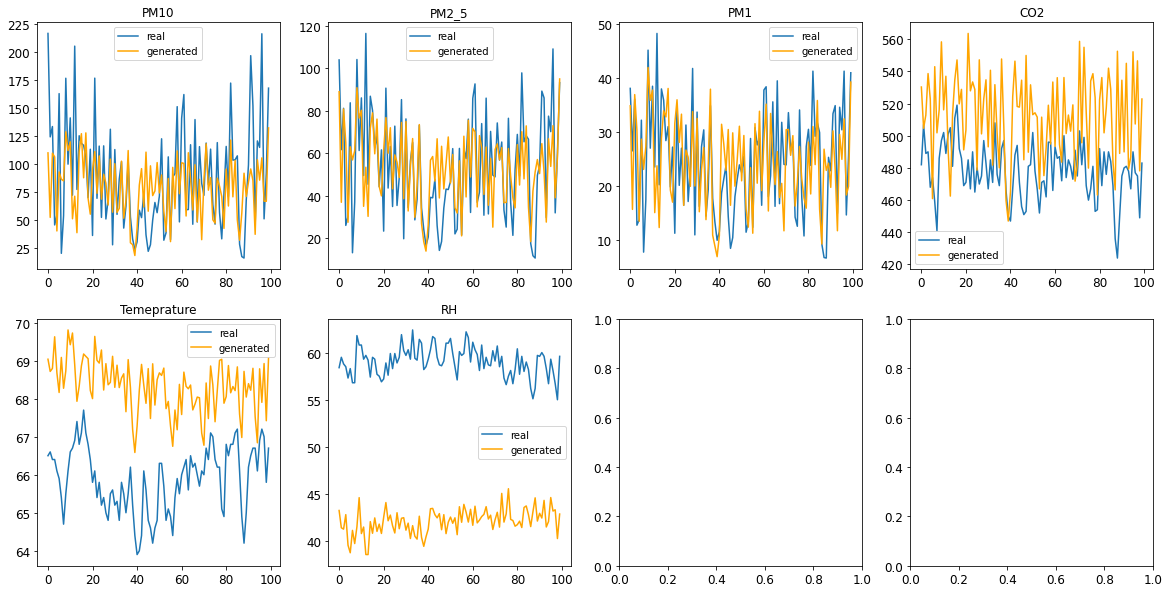

In [19]:
X_generated = scaler.inverse_transform(X_predict)
X_generated = X_generated.reshape(len(X_predict), n_features)
X_generated[X_generated<0] = 0 
np.save('X_generatedall.npy',X_generated)
        
    
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    #ax.flatten()[i].plot(X_generated[:,i+1], '-',c='orange', label='generated')
    ax.flatten()[i].plot(X_train[n:(n+ntimes+predict_points),i+1], '-', label='real')
    ax.flatten()[i].plot(X_generated[:,i+1], '-',c='orange', label='generated')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend()
    
plt.savefig('./output/Figures/Prediction/PM10entire_v'+str(k)+'_epoch_'+str(epochs)+'.png')

# CO2

In [20]:
control_variable = 1

In [21]:
np.random.seed(0)
tf.random.set_seed(0)

real_coding = X_train_concat[n,:,control_variable].reshape(1,-1)
real_coding = real_coding[:, :(ntimes)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_space])  
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

latent_values = optimize_coding(latent_values, real_coding, epochs, control_variable)
X_predict = list(generator(latent_values).numpy().reshape(-1,n_features))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,n_features:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(predict_points): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, epochs, control_variable)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,n_features:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (10

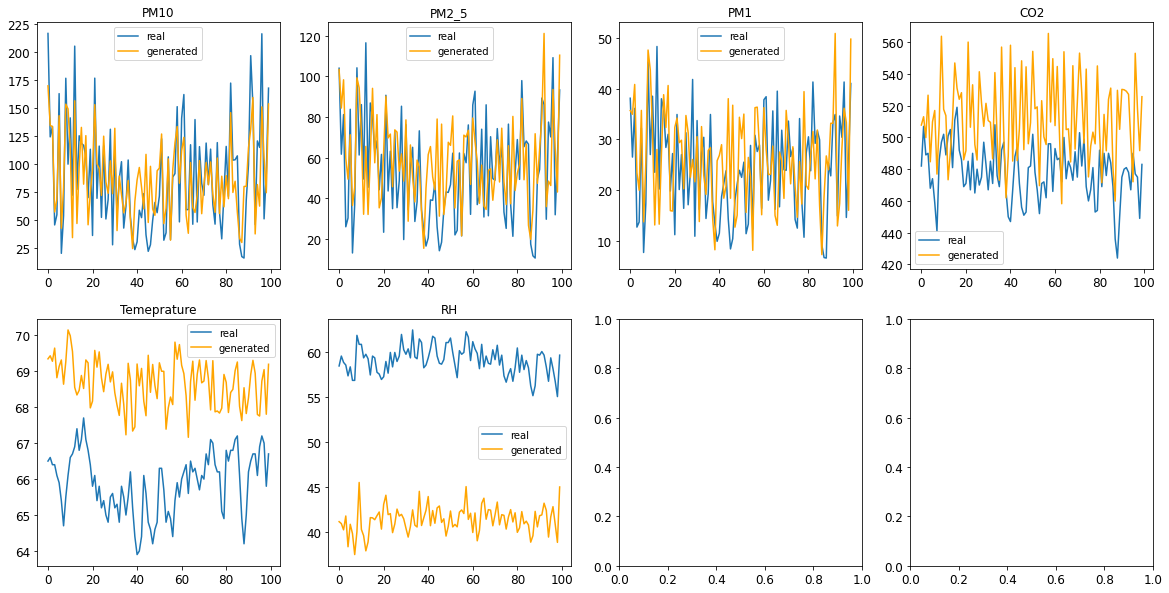

In [22]:
X_generated = scaler.inverse_transform(X_predict)
X_generated = X_generated.reshape(len(X_predict), n_features)

X_generated[X_generated<0] = 0 

fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    #ax.flatten()[i].plot(X_generated[:,i+1], '-o',c='orange', label='generated')
    ax.flatten()[i].plot(X_train[n:(n+ntimes+predict_points),i+1], '-', label='real')
    ax.flatten()[i].plot(X_generated[:,i+1], '-',c='orange', label='generated')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend()
    
plt.savefig('./output/Figures/Prediction/CO2_v'+str(k)+'_epoch_'+str(epochs)+'.png')

# RH

In [23]:
control_variable = 5

In [24]:
np.random.seed(0)
tf.random.set_seed(0)

real_coding = X_train_concat[n,:,control_variable].reshape(1,-1)
real_coding = real_coding[:, :(ntimes)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_space])  
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

latent_values = optimize_coding(latent_values, real_coding, epochs, control_variable)
X_predict = list(generator(latent_values).numpy().reshape(-1,n_features))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,n_features:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(predict_points): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, epochs, control_variable)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,n_features:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (10

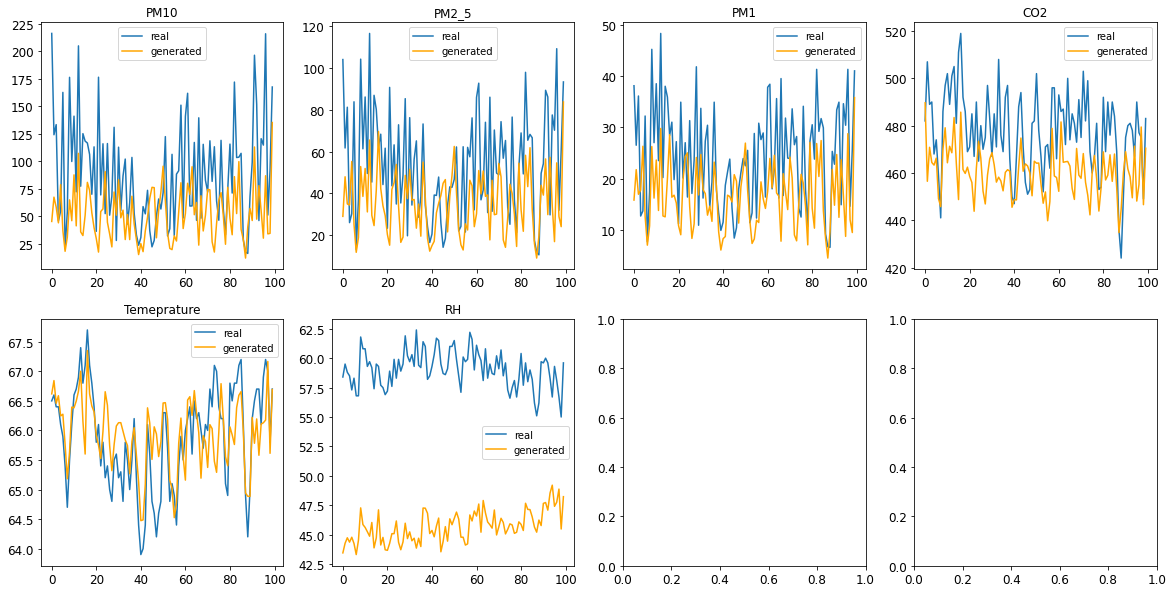

In [25]:
X_generated = scaler.inverse_transform(X_predict)
X_generated = X_generated.reshape(len(X_predict), n_features)

X_generated[X_generated<0] = 0 

fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    #ax.flatten()[i].plot(X_generated[:,i+1], '-o',c='orange', label='generated')
    ax.flatten()[i].plot(X_train[n:(n+ntimes+predict_points),i+1], '-', label='real')
    ax.flatten()[i].plot(X_generated[:,i+1], '-',c='orange', label='generated')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend()
    
plt.savefig('./output/Figures/Prediction/RH_v'+str(k)+'_epoch_'+str(epochs)+'.png')

# Temperature

In [26]:
control_variable = 6

In [27]:
np.random.seed(0)
tf.random.set_seed(0)

real_coding = X_train_concat[n,:,control_variable].reshape(1,-1)
real_coding = real_coding[:, :(ntimes)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_space])  
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

latent_values = optimize_coding(latent_values, real_coding, epochs, control_variable)
X_predict = list(generator(latent_values).numpy().reshape(-1,n_features))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,n_features:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(predict_points): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, epochs, control_variable)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,n_features:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (10

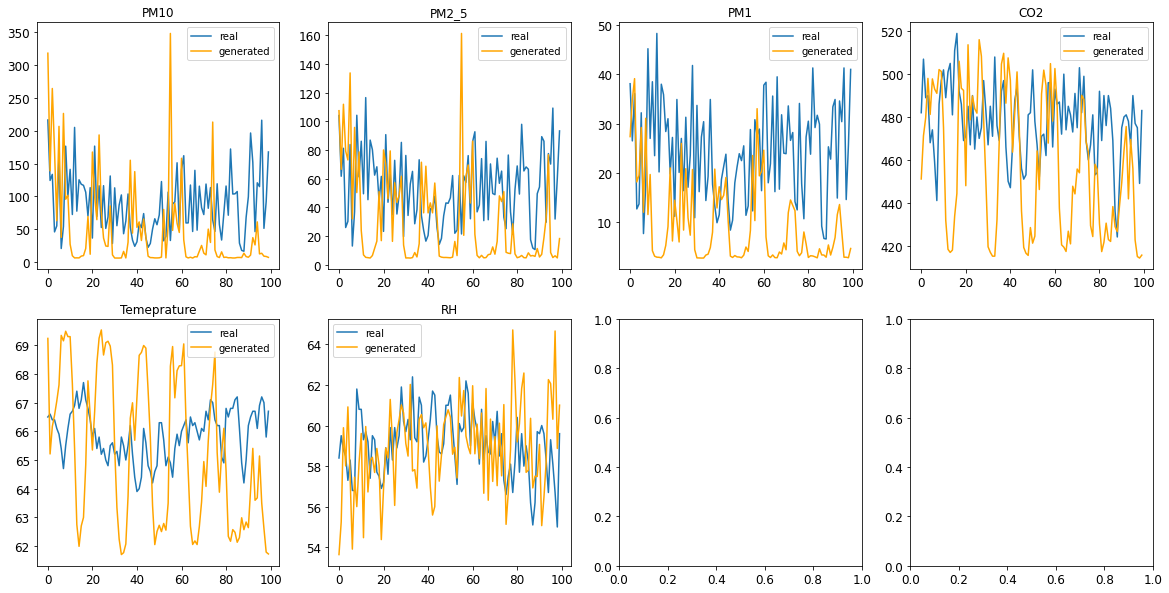

In [28]:
X_generated = scaler.inverse_transform(X_predict)
X_generated = X_generated.reshape(len(X_predict), n_features)

X_generated[X_generated<0] = 0 

fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    #ax.flatten()[i].plot(X_generated[:,i+1], '-',c='orange', label='generated')
    ax.flatten()[i].plot(X_train[n:(n+ntimes+predict_points),i+1], '-', label='real')
    ax.flatten()[i].plot(X_generated[:,i+1], '-',c='orange', label='generated')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend()
    
plt.savefig('./output/Figures/Prediction/Temp_v'+str(k)+'_epoch_'+str(epochs)+'.png')

# PM2.5

In [29]:
control_variable = 3

In [30]:
np.random.seed(0)
tf.random.set_seed(0)

real_coding = X_train_concat[n,:,control_variable].reshape(1,-1)
real_coding = real_coding[:, :(ntimes)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_space])  
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

latent_values = optimize_coding(latent_values, real_coding, epochs, control_variable)
X_predict = list(generator(latent_values).numpy().reshape(-1,n_features))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,n_features:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(predict_points): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, epochs, control_variable)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,n_features:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (10

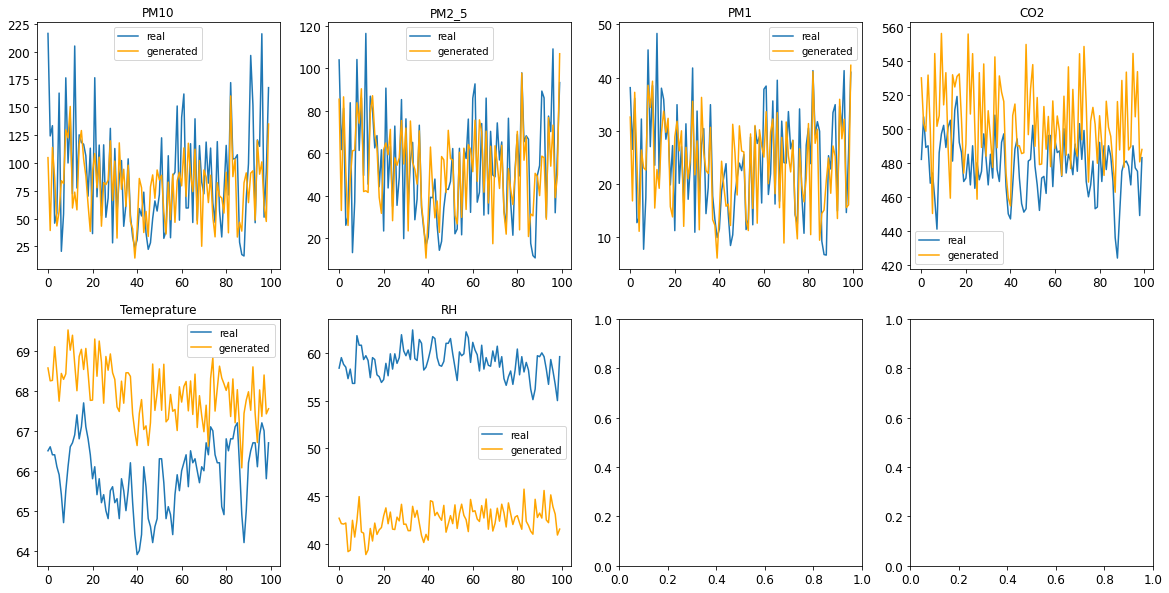

In [31]:
X_generated = scaler.inverse_transform(X_predict)
X_generated = X_generated.reshape(len(X_predict), n_features)

X_generated[X_generated<0] = 0 

fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    #ax.flatten()[i].plot(X_generated[:,i+1], '-',c='orange', label='generated')
    ax.flatten()[i].plot(X_train[n:(n+ntimes+predict_points),i+1], '-', label='real')
    ax.flatten()[i].plot(X_generated[:,i+1], '-',c='orange', label='generated')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend()
    
plt.savefig('./output/Figures/Prediction/PM2_5_v'+str(k)+'_epoch_'+str(epochs)+'.png')

# PM1

In [32]:
control_variable = 4

In [33]:
np.random.seed(0)
tf.random.set_seed(0)

real_coding = X_train_concat[n,:,control_variable].reshape(1,-1)
real_coding = real_coding[:, :(ntimes)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_space])  
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

latent_values = optimize_coding(latent_values, real_coding, epochs, control_variable)
X_predict = list(generator(latent_values).numpy().reshape(-1,n_features))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,n_features:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(predict_points): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, epochs, control_variable)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,n_features:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (100, 1)
output: (100, 1)
input: (10

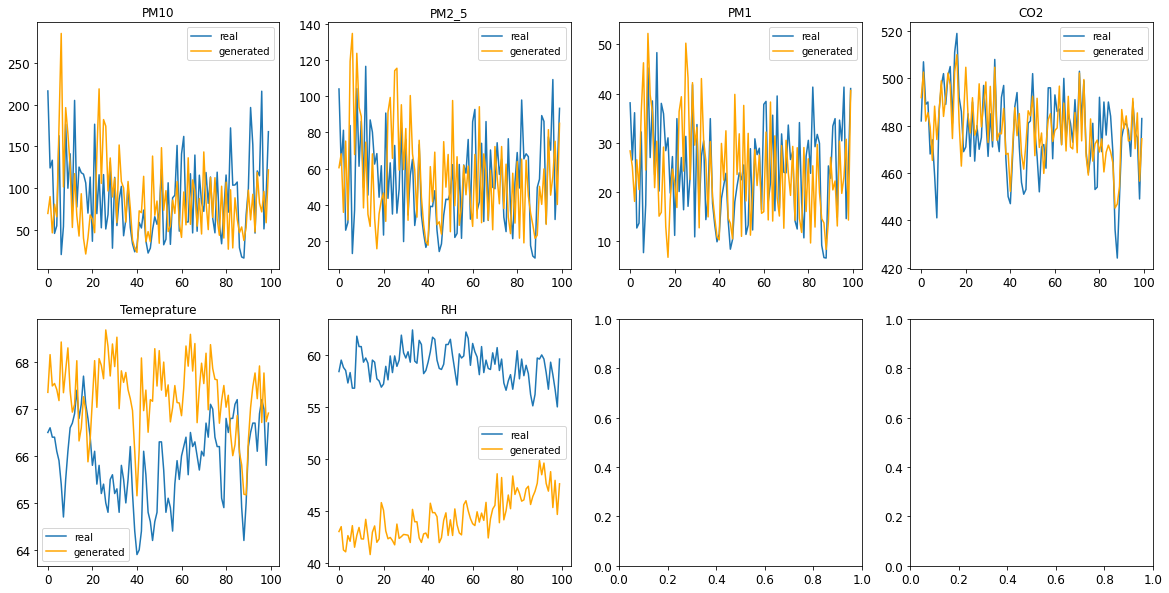

In [34]:
X_generated = scaler.inverse_transform(X_predict)
X_generated = X_generated.reshape(len(X_predict), n_features)

X_generated[X_generated<0] = 0 

fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    #ax.flatten()[i].plot(X_generated[:,i+1], '-',c='orange', label='generated')
    ax.flatten()[i].plot(X_train[n:(n+ntimes+predict_points),i+1], '-', label='real')
    ax.flatten()[i].plot(X_generated[:,i+1], '-',c='orange', label='generated')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend()
    
plt.savefig('./output/Figures/Prediction/PM1_v'+str(k)+'_epoch_'+str(epochs)+'.png')